In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torch.functional import F
from typing import cast
from tqdm import tqdm
import random


%matplotlib inline
while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())
DATA_DIR = "data"
NAMES_FILE_PATH = os.path.join(DATA_DIR, "names.txt")

/Users/cristian/Personal/Projects/nlp-playground


Load the words

In [2]:
with open(NAMES_FILE_PATH, "r") as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

Build the dictionary mapping of the characters to their corresponding integer values

In [3]:
chars = ["."] + sorted(list(set("".join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

Build the actual datased considering a sequence of block_size characters as input and the next character as the output

In [4]:
# training split, dev/validation split, test split
# 80% train, 10% dev, 10% test
def build_dataset(words, block_size=None):
    if block_size is None:
        block_size = 3

    X, Y = [], []

    # iterate over words
    for word in words:
        # define a 3-character context window
        context = [0] * block_size
        # iterate over characters in the word
        for char in word + ".":
            # get the index of the character
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            # slide the context window one character to the right
            context = context[1:] + [idx]
    # convert the data to PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [58]:
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_te, Y_te = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [59]:
X_tr.shape, Y_tr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [79]:
g = torch.Generator().manual_seed(42)
C = torch.randn(27, 10, generator=g, requires_grad=True)
W1 = torch.randn(30, 200, generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn(200, 27, generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [80]:
sum(p.nelement() for p in parameters)

11897

In [71]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [87]:
lri = []
lossi = []
stepi = []
batch_size = 128
index = 0
n_iterations = 50000
lr = 0.01

In [92]:
progress_bar = tqdm(range(n_iterations), desc=f"Training")
for i in progress_bar:
    # build minibatch
    idx = torch.randint(0, X_tr.shape[0], (batch_size,))

    # Compute embeddings
    emb = C[X_tr[idx]]

    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
    logits = h @ W2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()

    # Compute loss
    loss = F.cross_entropy(logits, Y_tr[idx])
    progress_bar.set_postfix(loss=loss.item())
    # print(f"loss: {loss.item()}")

    for p in parameters:
        p.grad = None
    loss.backward()

    # Update weights
    # lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
    # tqdm.write(f"loss: {loss.item()}")
    # # Track statistics
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(index)
    index += 1

Training: 100%|██████████| 50000/50000 [00:44<00:00, 1124.60it/s, loss=2.18]


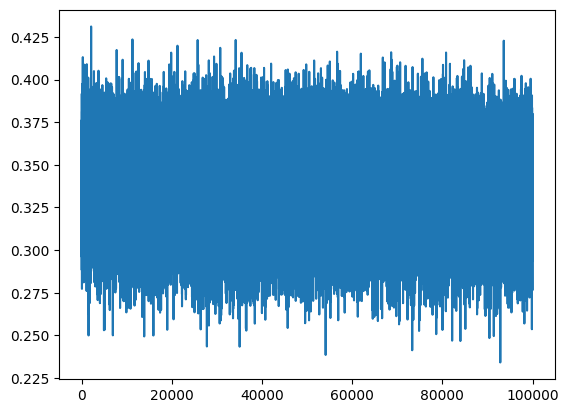

In [93]:
plt.plot(stepi, lossi)
plt.show()

In [94]:
emb = C[X_tr]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss

tensor(2.1655, grad_fn=<NllLossBackward0>)

In [95]:
emb = C[X_dev]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1916, grad_fn=<NllLossBackward0>)

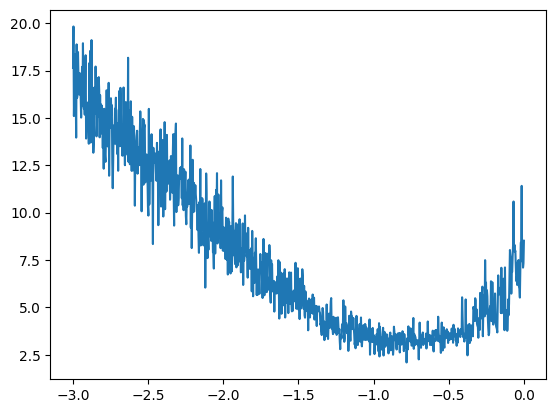

In [ ]:
plt.plot(lri, lossi)

In [52]:
C.shape

torch.Size([27, 2])

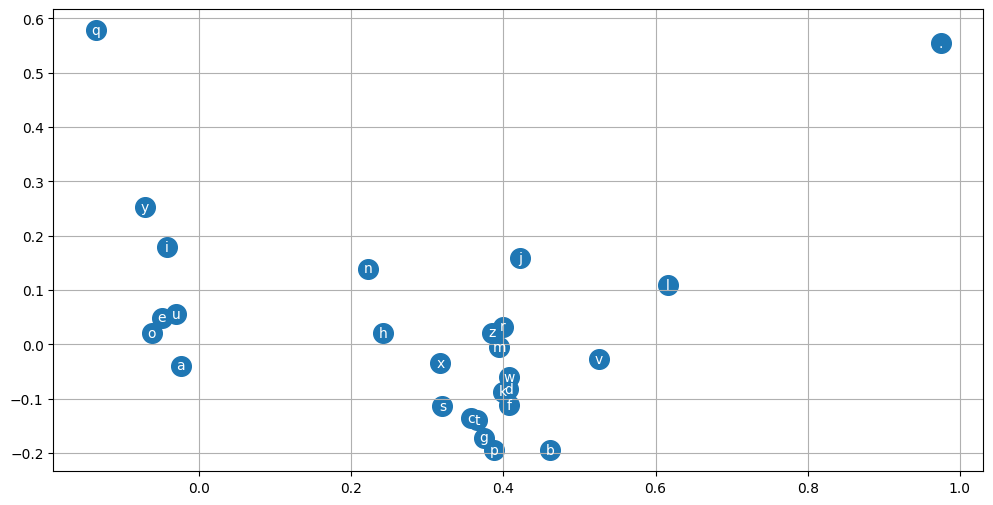

In [51]:
plt.figure(figsize=(12, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [97]:
g = torch.Generator().manual_seed(42)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

anuelen.
tia.
marian.
davius.
amillaylen.
kemarce.
man.
epiacenden.
dazi.
kence.
jordon.
kalla.
mikhlynna.
cvahia.
aczalin.
tian.
tiyan.
marotte.
jena.
judgan.
